In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import os

In [2]:
dw_dir = r'/home/cczephyrin/projects/political embedding/data/dwnomiateandmore/'

dws = pd.read_csv(dw_dir + r'HSall_members_filtered.csv', sep = ',')

In [3]:
# dws

id_dw = dws.groupby('bioguide_id')[['nominate_dim1', 'nominate_dim2']].mean()

In [4]:
id_dw

,nominate_dim1,nominate_dim2
bioguide_id,,
A000014,-0.432,-0.026
A000022,-0.429,-0.165
A000031,-0.396,-0.127
A000055,0.365,0.595
A000069,-0.419,0.273
...,...,...
Y000066,0.442,-0.038
Z000004,0.438,-0.461
Z000008,0.270,-0.963


In [5]:
# load data

rs_dir1 = r'/home/cczephyrin/projects/political embedding/results/frames/framing_train_v116.01/msk_0.1_epc_10/'
rs_dir2 = r'/home/cczephyrin/projects/political embedding/results/frames/framing_train_v116.01/msk_0.05_epc_10/'
data_dir = r'/home/cczephyrin/projects/political embedding/training_vec/'

In [6]:
# round 3
Zbars = np.load(rs_dir1 + r'Zbars_3.npy') # zbar of congressmen in trump and obama era

In [7]:
Zbars.shape

(1023, 50)

In [8]:
Slants_pred = np.load(rs_dir2 + r'Slants_pred_2.npy')

In [9]:
Slants_pred.shape

(206899,)

In [10]:
Parties_true = np.load(data_dir + r'obama_trump_congress_parties_no_switcher.npy') # parties of congressmen in obama trump era

In [11]:
Parties_true.shape

(1023,)

In [12]:
ids_true = np.load(data_dir + r'obama_trump_congress_ids_no_switcher.npy', allow_pickle = True)

In [13]:
ids_true.shape

(1023,)

In [14]:
# load As, date for slant calculation
date = np.load(os.path.join(data_dir, 'sorted_date_1991_{}.npy'.format('2020-10-04')))
inx = date>20090000

In [15]:
As_all = np.load(os.path.join(data_dir, 'cr_author_dummy_1991_{}.npy'.format('2020-10-04')))[inx]

In [16]:
As_all.shape

(208292, 1674)

In [17]:
# filter out switchers
true_switchers_ = ['A000361','B000229', 'B001264', 'D000168', 'G000280', 'H000067', 'H000390', 'L000119', 'P000066', 'T000058', 'C000077','F000257', 'G000557', 
'S000320', 'S000709','J000072']

independents = ['S000033', 'B001237', 'K000383']

true_switchers =independents + true_switchers_

As_ids = np.load(os.path.join(data_dir, 'cr_author_id_1991_{}.npy'.format('2020-10-04')),allow_pickle=True)

# print(len(As_ids))

switchdummies = [list(As_ids).index(i) for i in true_switchers if i in As_ids]

switch_speech_bool = As_all[:, switchdummies].sum(axis = -1)==1

# sum(switch_speech_bool),len(switch_speech_bool)

switch_id = np.arange(len(switch_speech_bool))[switch_speech_bool]
train_id_wo_switchers = np.setdiff1d(np.arange(len(As_all)), switch_id) # for model eval, exclude switchers, add them back for insights




In [18]:
As = As_all[train_id_wo_switchers]
As.shape

(206899, 1674)

In [19]:
Slants_byid_ = np.matmul(As.T, Slants_pred)/(np.sum(As.T, axis = 1)+0.000001)
spoken = np.sum(As.T, 1)!=0

In [20]:
Slants_byid = Slants_byid_[spoken]

In [21]:
((Slants_byid>0) == Parties_true).mean()

0.9315738025415444

In [35]:
## check Zbar
import math
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [36]:
pca = PCA(n_components=2)
Zbar_pca = pca.fit_transform(Zbars)
x= Zbar_pca[:, 0]
y = Zbar_pca[:, 1]

In [ ]:
c = np.array(['r','b'])[Parties_true*1]
# marker = np.array(["o", "+"])[Parties_true*1]

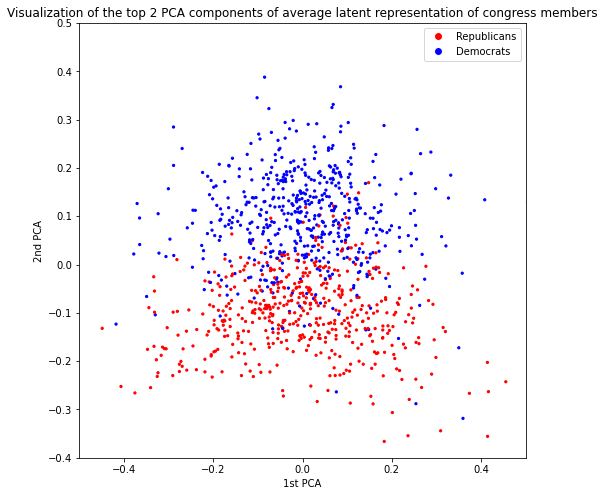

<Figure size 432x288 with 0 Axes>

In [87]:

# legend_elements = [Line2D([0], [0], color='b', lw=4, label='Line'),
#                    Line2D([0], [0], marker='o', color='w', label='Scatter',
#                           markerfacecolor='g', markersize=15),
#                    Patch(facecolor='orange', edgecolor='r',
#                          label='Color Patch')]

legend_elements = [             Line2D([0], [0], marker='o', color='w', label='Republicans',
                          markerfacecolor='r', markersize=8),Line2D([0], [0], marker='o', color='w', label='Democrats',
                          markerfacecolor='b', markersize=8)
                  ]
plt.figure(figsize = (8, 8))
plt.scatter(x, y, s = 5,c = c)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.4, 0.5)


plt.title("Visualization of the top 2 PCA components of average latent representation of congress members")
plt.legend(handles=legend_elements, loc='upper right')
plt.xlabel('1st PCA')
plt.ylabel('2nd PCA')
plt.show()
plt.savefig(rs_dir2 + 'PCA vs party label.png')

In [23]:
##
slant_dw1 = []
p = []
for i, slant in enumerate(Slants_byid):
    tid = ids_true[i]
    try:
        dw1 = id_dw.loc[tid, 'nominate_dim1']
        slant_dw1.append([slant, dw1])
        p.append(Parties_true[i])
    except:
        pass


In [24]:
slant_dw1 = np.array(slant_dw1)
p = np.array(p)

In [25]:
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr
  

In [30]:
def normalize2(arr):
    z = 1/(1 + np.exp(-arr))
    return 2.0*z -1.0
        
    

In [41]:
x = np.array(normalize(slant_dw1[:, 0], -1, 1))
y  = np.array(normalize(slant_dw1[:, 1], -1, 1))

# x = np.array(normalize2(slant_dw1[:, 0]))
# y  = np.array(normalize2(slant_dw1[:, 1]))

In [42]:
import scipy as sp

In [43]:
linreg = sp.stats.linregress(x, -y)

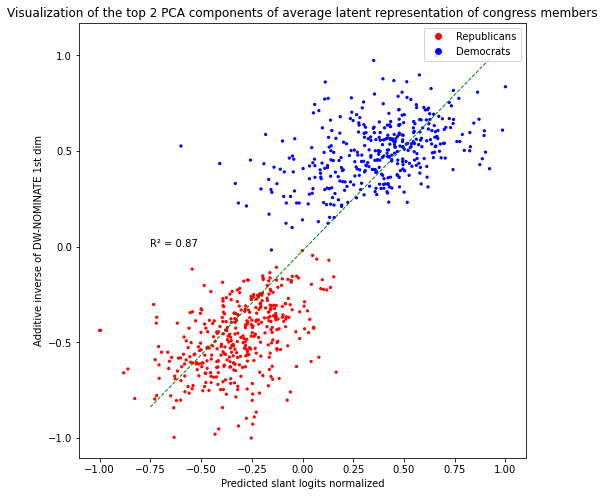

In [44]:
legend_elements = [             Line2D([0], [0], marker='o', color='w', label='Republicans',
                          markerfacecolor='r', markersize=8),Line2D([0], [0], marker='o', color='w', label='Democrats',
                          markerfacecolor='b', markersize=8)]
plt.figure(figsize = (8, 8))
c2 = np.array(['r', 'b'])[p*1]
plt.title("Visualization of the top 2 PCA components of average latent representation of congress members")
plt.legend(handles=legend_elements, loc='upper right')
plt.xlabel('Predicted slant logits normalized')
plt.ylabel('Additive inverse of DW-NOMINATE 1st dim')                  
plt.scatter(x, -y, s = 5, c = c2)
lx = np.linspace(-0.75, 1, 20)

plt.plot(lx, linreg.intercept + linreg.slope*lx, 'g--', linewidth = 1)
plt.text(-0.75, 0, 'R\u00B2 = %0.2f' % (linreg.rvalue))
plt.show()

In [45]:
linreg.rvalue

0.8660112546396573

In [136]:


plt.show()

In [129]:
linreg.slope*y

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [130]:
y

[-0.6000000000000001,
 -0.5964391691394658,
 0.34599406528189913,
 -0.5845697329376853,
 -0.4397626112759644,
 0.6391691394658754,
 0.29732937685459926,
 -0.24510385756676556,
 -0.3317507418397626,
 -0.2225519287833828,
 0.3483679525222554,
 0.5976261127596441,
 0.6890207715133532,
 0.3293768545994067,
 0.3649851632047476,
 -0.6439169139465875,
 -0.429080118694362,
 0.7091988130563798,
 -0.3068249258160237,
 0.5359050445103857,
 0.3721068249258159,
 0.4979228486646885,
 0.5394658753709201,
 0.3056379821958457,
 -0.3388724035608309,
 -0.6949554896142435,
 0.3056379821958457,
 -0.5667655786350148,
 -0.4350148367952522,
 -0.4599406528189911,
 0.3780415430267061,
 -0.4029673590504451,
 -0.4219584569732937,
 -0.5940652818991097,
 0.4219584569732937,
 0.5216617210682493,
 0.2807121661721068,
 -0.3697329376854599,
 -0.4017804154302671,
 -0.6213649851632048,
 -0.30207715133531166,
 0.5323442136498517,
 -0.5964391691394659,
 -0.6011869436201779,
 0.4338278931750741,
 0.5311572700296736,
 0.4492